Here we briefly demonstrate the use of the symmetric kernel. Start by importing GPy and the Symmetric kernel add on from the symmetric.py file.

In [1]:
import GPy
import numpy as np
from symmetric import Symmetric

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

The usage is very simple. We create a kernel as usual, and then to make a symmetric version of that kernel, we need to specify the permuation matrix describing the symmetry group that applies to the kernel. For example

In [2]:
k = GPy.kern.RBF(2, variance = 2, lengthscale=0.25)
permutation = np.array([[0,1],[1,0]])
k2 = Symmetric(k, permutation)

So here, we have said that we have 2 input variables, and that we want the resulting function to be symmetric in x1 and x2, i.e., swapping x1 and x2 should have no effect. 

We can now try simulating from the prior on a grid. This should give us a symmetric shape.

<a list of 14 text.Text objects>

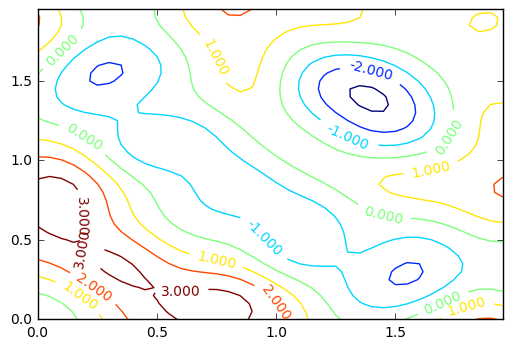

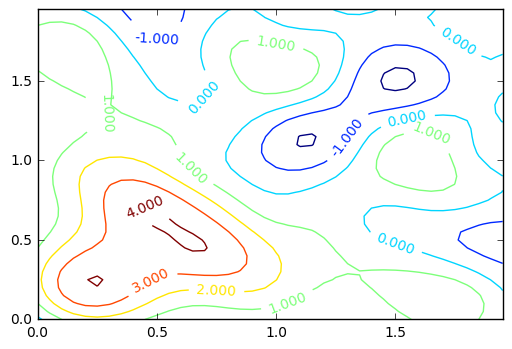

In [3]:
xgrid1, xgrid2 = np.meshgrid(np.arange(0,2,0.05), np.arange(0,2,0.05))
xgrid =np.concatenate((xgrid1.reshape((-1,1)), xgrid2.reshape((-1,1))), 1)

mu = np.zeros(xgrid.shape[0])

K3 = k2.K(xgrid)+np.eye(xgrid.shape[0])*0.000001
Z = np.random.multivariate_normal(mu,K3,1)
Z2 = np.random.multivariate_normal(mu,K3,1)
plt.figure(1)
CS = plt.contour(xgrid1[0,:], xgrid2[:,0], Z.reshape(xgrid1.shape[0], xgrid1.shape[0]))
plt.clabel(CS, inline=1, fontsize=10)

plt.figure(2)
CS = plt.contour(xgrid1[0,:], xgrid2[:,0], Z2.reshape(xgrid1.shape[0], xgrid1.shape[0]))
plt.clabel(CS, inline=1, fontsize=10)


Now let's check we can update the model with some data. We'll randomly pick 100 elements to keep, discard any in the for which x2>x1.


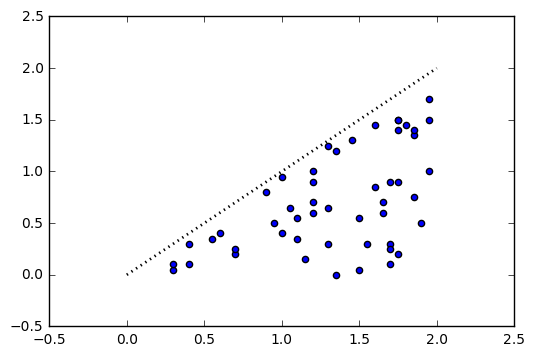

In [20]:
keep = np.random.choice(Z.shape[1], 100)
x= xgrid[keep,:]
keep2 = x[:,0]>x[:,1] 
x = x[keep2,:]
y = Z[0,keep]
y = y[keep2]
y = y.reshape(-1,1)


plt.scatter(x[:,0], x[:,1])
plt.plot([0, 2], [0, 2], 'k', linestyle='dotted',lw=2)



Let's now fit the GP model and check that it has worked.

In [13]:

m=GPy.models.GPRegression(x, y, k2)
m.Gaussian_noise.fix(0.001)
m.randomize()
m.optimize_restarts(10)
print(m)


Optimization restart 1/10, f = 6272.715247312044
Optimization restart 2/10, f = 23.848066672289875
Optimization restart 3/10, f = 2557.8896291142296
Optimization restart 4/10, f = 671.6446406008154
Optimization restart 5/10, f = 2716.4297196452217
Optimization restart 6/10, f = 287.25635023645617
Optimization restart 7/10, f = 10540.46257025715
Optimization restart 8/10, f = 122.44337941376133
Optimization restart 9/10, f = 24.082769178635957
Optimization restart 10/10, f = 8119.262015231631

Name : GP regression
Objective : 23.848066672289875
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.                 |           value  |  constraints  |  priors
  Symmetric_rbf.rbf.variance     |   2.88968793414  |      +ve      |        
  Symmetric_rbf.rbf.lengthscale  |  0.261232078766  |      +ve      |        
  Gaussian_noise.variance        |           0.001  |   fixed +ve   |        


We'll now plot the fitted surface along with the data points that we sampled. I'll label the values so that it is possible to see the fitted surface is doing the right thing.

 /home/sm1rw/anaconda3/lib/python3.5/site-packages/matplotlib/text.py:2130: UserWarning:You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


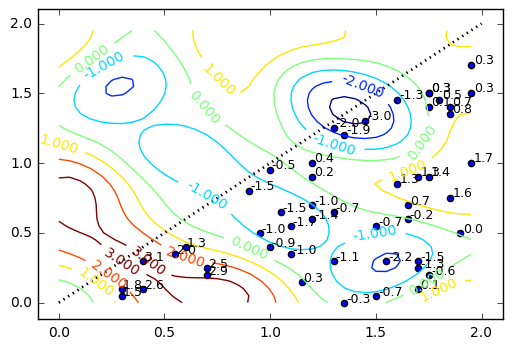

In [28]:

ypredmean, ypredvar = m._raw_predict(xgrid, full_cov=True)
 # have to dp full cov as not implemented Kdiag yet
plt.figure(2)
CS2 = plt.contour(xgrid1[0,:], xgrid2[:,0], ypredmean.reshape(xgrid1.shape[0], xgrid1.shape[0]))
plt.scatter(x[:,0], x[:,1])
# but is it working?
plt.clabel(CS2, inline=1, fontsize=10)
for i in np.arange(y.shape[0]):
    plt.annotate('%.1f' % y[i], xy=x[i,:], textcoords='offset points', fontsize=9)

plt.plot([0, 2], [0, 2], 'k', linestyle='dotted',lw=2)

This seems to have worked. Note that we've successfully learn't the surface in the upper half plane even though no data were recorded there. We can also plot the true contour surface on top of the estimated one and observe the similarity.

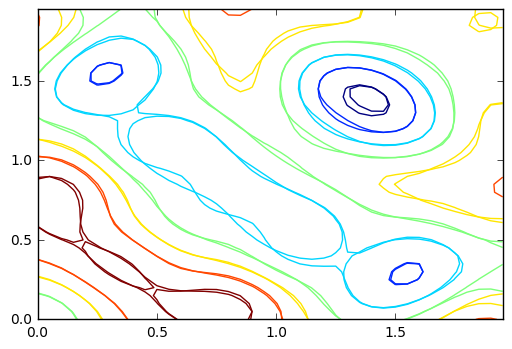

In [34]:
plt.figure(4)
CS2 = plt.contour(xgrid1[0,:], xgrid2[:,0], ypredmean.reshape(xgrid1.shape[0], xgrid1.shape[0]))
CS = plt.contour(xgrid1[0,:], xgrid2[:,0], Z.reshape(xgrid1.shape[0],xgrid1.shape[0]))

Finally, let's look at the variance and check that is also symmetric.

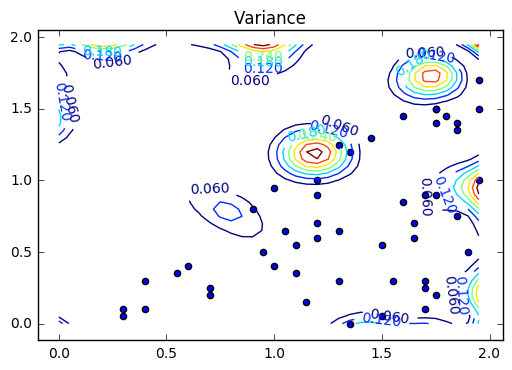

In [35]:
CS3 = plt.contour(xgrid1[0,:], xgrid2[:,0], ypredvar.diagonal().reshape(xgrid1.shape[0], xgrid1.shape[0]))
plt.scatter(x[:,0], x[:,1])
# but is it working?
plt.clabel(CS3, inline=1, fontsize=10)
plt.title('Variance')